# 23 - Défis liés à l'hétérogénéité des effets et à la non-linéarité

Prédire les effets des traitements au niveau de l'unité est extrêmement difficile en raison de l'absence de vérité terrain. Comme nous n'observons qu'un seul résultat potentiel $T(t)$, nous ne pouvons pas l'estimer directement. Au lieu de cela, nous devons nous appuyer sur des transformations cibles (qui peuvent également être considérées comme des fonctions de perte intelligemment conçues) pour estimer les effets des traitements conditionnels uniquement en espérance. Mais ce n'est pas le seul défi. En raison de la nature insaisissable des effets des traitements, leurs estimateurs sont souvent assez bruyants. Cela a des conséquences pratiques considérables pour les applications où nous souhaitons segmenter les unités en fonction de leur effet de traitement, comme lorsque nous voulons effectuer une allocation de traitement personnalisée.

Nous verrons maintenant que, parfois, nous pouvons obtenir une meilleure segmentation des effets de traitement si nous ne tentons pas directement d'estimer l'effet de traitement conditionnel moyen (CATE), mais si nous nous concentrons plutôt sur une autre cible proxy, qui a généralement moins de variance. Un cas courant où cela se produit est lorsque la variable de résultat d'intérêt $Y$ est binaire.

## Effets des traitements sur des résultats binaires

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")


In [3]:
from typing import List

import numpy as np
import pandas as pd
from toolz import curry, partial

@curry
def avg_treatment_effect(df, treatment, outcome):
    return df.loc[df[treatment] == 1][outcome].mean() - df.loc[df[treatment] == 0][outcome].mean()
    
    

@curry
def cumulative_effect_curve(df: pd.DataFrame,
                            treatment: str,
                            outcome: str,
                            prediction: str,
                            min_rows: int = 30,
                            steps: int = 100,
                            effect_fn = avg_treatment_effect) -> np.ndarray:
    
    size = df.shape[0]
    ordered_df = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_rows, size, size // steps)) + [size]
    return np.array([effect_fn(ordered_df.head(rows), treatment, outcome) for rows in n_rows])


@curry
def cumulative_gain_curve(df: pd.DataFrame,
                          treatment: str,
                          outcome: str,
                          prediction: str,
                          min_rows: int = 30,
                          steps: int = 100,
                          effect_fn = avg_treatment_effect) -> np.ndarray:
    

    size = df.shape[0]
    n_rows = list(range(min_rows, size, size // steps)) + [size]

    cum_effect = cumulative_effect_curve(df=df, treatment=treatment, outcome=outcome, prediction=prediction,
                                         min_rows=min_rows, steps=steps, effect_fn=effect_fn)

    return np.array([effect * (rows / size) for rows, effect in zip(n_rows, cum_effect)])


Voici un problème incroyablement courant auquel vous pourriez être confronté si vous travaillez pour une entreprise technologique : la direction souhaite augmenter la conversion des clients vers votre produit par le biais de certains types de nudges. Par exemple, ils pourraient vouloir augmenter le nombre d'installations d'applications en offrant un bon de 10 BRL pour des achats in-app. Ou offrir une course gratuite la première fois que vous utilisez leur application de covoiturage. Ou réduire les frais de transaction pendant les trois premiers mois sur leur plateforme d'investissement. Étant donné que les nudges sont souvent coûteux, ils aimeraient ne pas avoir à le faire pour tout le monde. Il serait plutôt intéressant de n'utiliser le nudge pour stimuler la conversion que sur les clients les plus sensibles à celui-ci.

En termes d'inférence causale, vous pouvez probablement deviner maintenant que ce type de problème commercial relève de l'hétérogénéité des effets de traitement (TEH). Plus précisément, vous avez un nudge coûteux comme traitement $T$, la conversion comme résultat binaire $Y$ et des caractéristiques pré-traitement spécifiques aux clients comme $X$. Vous pourriez alors estimer l'effet moyen conditionnel du traitement $E[Y_1 - Y_0|X]$ (ou $E[Y'(T)|X]$ si le traitement est continu) avec quelque chose comme le Double/Debiased ML et finalement cibler avec le nudge uniquement les clients avec l'effet de traitement estimé le plus élevé. En termes commerciaux, vous personnaliseriez votre stratégie de conversion. Vous trouveriez un segment de clients avec une forte incrémentalité de conversion et utiliseriez les nudges uniquement sur eux.

Cependant, il y a une complication ici qui rend l'approche TEH moins évidente. Le fait que le résultat soit binaire complique considérablement les choses. Comme cela est un peu contre-intuitif, je préfère d'abord montrer ce qui se passe, puis expliquer pourquoi cela se produit.

## Simulation de Données

Gardons cela très simple, mais toujours pertinent. Nous allons simuler le traitement, `nudge`, comme étant complètement aléatoire, tiré d'une loi de Bernoulli avec $p=0.5$. Cela signifie que le traitement est attribué selon un tirage à pile ou face équitable. Cela signifie également qu'il n'y a pas de confusion dont nous devons nous préoccuper.

$ nudge \sim \mathcal{B}(0.5) $

Ensuite, simulons les covariables des clients `âge` et `revenu` en suivant une distribution Gamma. Ce sont les informations que vous connaissez sur le client et donc, vous souhaitez personnaliser en fonction de celles-ci. En d'autres termes, vous souhaitez trouver des groupes de clients définis par l'âge et le revenu de manière à ce qu'un groupe soit très réactif au traitement `nudge`.

$ âge \sim G(10, 4) $

$ revenu \sim G(20, 2) $

Enfin, nous allons simuler la conversion. Pour cela, nous allons d'abord **créer une variable latente qui suit un modèle linéaire** avec du bruit aléatoire. Il est important de noter que le `revenu` est très prédictif de $Y_{latent}$, mais **il ne modifie pas l'effet du traitement**. En termes simples, le nudge augmente $Y_{latent}$ de la même manière pour tous les niveaux de `revenu`. En revanche, l'`âge` n'affecte $Y_{latent}$ que par son interaction avec le traitement `nudge`.

$Y_{latent} \sim N(-4.5 + 0.001 \ revenu + nudge + 0.01 \ nudge \ âge, 1)$

Une fois que nous avons $Y_{latent}$, nous pouvons simuler la `conversion` en la définissant comme $Y_{latent}>x$. D'abord, fixons `x=0` pour que la conversion soit d'environ 50 %. C'est-à-dire qu'en moyenne, 50 % des clients convertissent vers notre produit.

$conversion = 1\{Y_{latent} > 0\}$

In [4]:
np.random.seed(123)

n = 100000
nudge = np.random.binomial(1, 0.5, n)
age = np.random.gamma(10, 4, n)
estimated_income = np.random.gamma(20, 2, n)*100

latent_outcome = np.random.normal(-4.5 + estimated_income*0.001 + nudge + nudge*age*0.01)
conversion = (latent_outcome > .1).astype(int)

Stockons également toutes les données dans un DataFrame pour plus de commodité. Vérifions aussi que, effectivement, la conversion moyenne est proche de 50 %.

In [5]:
df = pd.DataFrame(dict(conversion=conversion,
                       nudge=nudge,
                       age=age,
                       estimated_income=estimated_income,
                       latent_outcome=latent_outcome))

df.mean()

conversion             0.518260
nudge                  0.500940
age                   40.013487
estimated_income    3995.489527
latent_outcome         0.197076
dtype: float64

Quant à l'effet moyen du traitement, étant donné que le traitement a été randomisé, nous pouvons l'estimer comme la simple différence de moyennes entre les groupes traités et les groupes de contrôle : $E[Y|T=1] - E[Y|T=0]$. Voyons donc à quoi ressemblent ces moyennes de traitement. Nous les examinerons à la fois pour le résultat latent et pour la perspective de conversion. Il y a quelque chose d'important à observer ici.

In [6]:
df.groupby("nudge")[["latent_outcome", "conversion"]].mean()

,latent_outcome,conversion
nudge,,
0,-0.505400,0.320503
1,0.896916,0.715275


In [7]:
avg_treatment_effect(df, "nudge", "latent_outcome")

1.4023163965477656

In [8]:
avg_treatment_effect(df, "nudge", "conversion")

0.39477273768476406

L'ATE (effet moyen du traitement) pour le résultat latent est assez simple. D'après notre modèle de génération de données, nous savons que cet effet devrait être de `1 + avg(age)*0.01`. Et puisque l'âge moyen est d'environ 40 ans, cela nous donne un ATE d'environ 1,4. Là où les choses deviennent un peu plus intéressantes (et compliquées), c'est pour l'ATE de la conversion. **Étant donné que la conversion est bornée entre 0 et 1, son ATE ne sera pas linéaire**. Par conséquent, nous ne pouvons pas le déduire à partir d'une formule simple comme nous l'avons fait pour le résultat latent (il existe une formule, mais elle est assez compliquée). Disons simplement que l'effet est plus faible. Et cela a du sens, non ? En effet, il est impossible que le traitement augmente la conversion de 1,4 point, simplement parce que la conversion ne peut pas dépasser 100%. Maintenant, je veux que vous gardiez cela en tête, car c'est crucial pour comprendre ce que nous verrons ensuite.

Parlons maintenant des effets moyens conditionnels du traitement (CATE). En regardant notre processus de génération de données, nous savons avec certitude que `estimated_income` (revenu estimé) prédit la conversion mais ne modifie pas l'effet du nudge sur la conversion. Par conséquent, segmenter nos clients en fonction de `estimated_income` générera des segments avec le même effet de traitement. En revanche, `age` n'affecte la conversion que par son interaction avec le nudge. Ainsi, différents segments d'âge réagiront très différemment au traitement, tandis que différents segments de revenu ne réagiront pas de manière significative. En d'autres termes, `estimated_income` ne devrait pas être une bonne variable de personnalisation, alors que `age` le devrait.

Une façon de voir cela est à travers la courbe d'effet cumulatif. La courbe pour `age` devrait commencer très loin de l'ATE et converger lentement vers celui-ci, tandis que la courbe pour `estimated_income` devrait simplement fluctuer autour de l'ATE. C'est exactement ce que nous voyons lorsque nous traçons la courbe d'effet cumulatif pour l'effet du nudge sur le résultat latent.

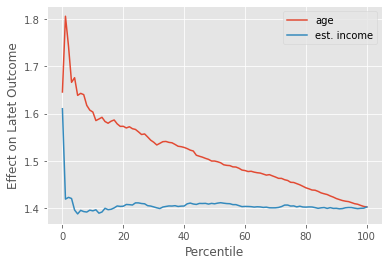

In [9]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "latent_outcome", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Latet Outcome");

Encore une fois, le résultat latent est très agréable. En raison de sa linéarité, nos attentes correspondent assez bien à la réalité. Mais dans la vie réelle, nous ne nous soucions pas (et n'avons pas) du résultat latent. Tout ce que nous avons, c'est la conversion. En ce qui concerne la conversion, les choses semblent beaucoup plus compliquées. Si nous traçons les courbes d'effet cumulatif, `age` montre encore une certaine hétérogénéité des effets de traitement, en commençant au-dessus de l'ATE et en convergeant lentement vers celui-ci. Cela signifie que plus l'âge est élevé, plus l'effet du traitement est important. Jusqu'ici, tout va bien. C'est ce à quoi nous nous attendions.

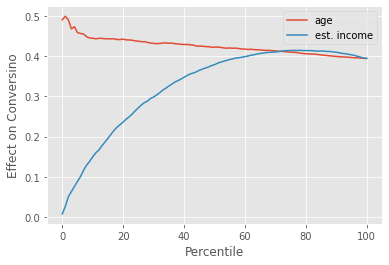

In [10]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino");

Cependant, nous constatons également une **grande hétérogénéité des effets de traitement** en fonction de `estimated_income`. Les clients ayant un revenu estimé plus élevé ont un effet de traitement beaucoup plus faible, ce qui fait que la courbe d'effet cumulatif descend jusqu'à zéro au début, puis converge lentement vers l'ATE. Cela nous indique que, en ce qui concerne la personnalisation, `estimated_income` générera des segments avec plus d'hétérogénéité des effets de traitement (TEH) par rapport aux segments que nous obtiendrions avec `age`.

C'est gênant, n'est-ce pas ? Comment se fait-il que la caractéristique que nous savons influencer l'hétérogénéité des effets, `age`, soit pire pour la personnalisation par rapport à une caractéristique (`estimated_income`) dont nous savons qu'elle ne modifie pas l'effet du traitement ? La réponse réside dans la **non-linéarité de la fonction de résultat**. Bien que `estimated_income` ne modifie pas l'effet du nudge sur le résultat latent, il le fait une fois que nous transformons ce résultat latent en conversion (au moins indirectement). La conversion n'est pas linéaire. Cela signifie que **sa dérivée change en fonction de l'endroit où l'on se situe**. Puisque la conversion ne peut atteindre que 1, si elle est déjà très élevée, il sera difficile de l'augmenter. En d'autres termes, la dérivée d'une conversion élevée est très faible. Mais comme la conversion est également limitée à zéro, elle aura également une faible dérivée si elle est déjà très basse. La conversion suit une forme en S, avec des dérivées faibles aux deux extrémités. Nous pouvons le constater en traçant la conversion moyenne par tranches de revenu estimé (par tranches de 100).

<AxesSubplot:xlabel='estimated_income_bins'>

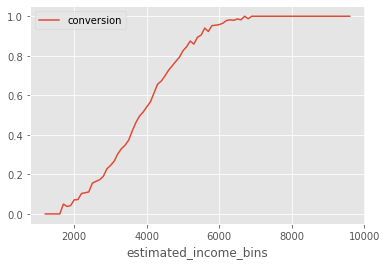

In [11]:
(df
 .assign(estimated_income_bins=(df["estimated_income"]/100).astype(int)*100)
 .groupby("estimated_income_bins")
 [["conversion"]]
 .mean()
 .plot()
);

Remarquez comment la pente (dérivée) de cette courbe est très faible lorsque la conversion est très élevée. Elle est également faible lorsque la conversion est très basse (bien que cela soit plus difficile à voir en raison du faible échantillon dans cette région). Avec ces informations, nous pouvons maintenant expliquer pourquoi `estimated_income` génère des segments avec une forte hétérogénéité des effets de traitement.

Étant donné que `estimated_income` est hautement prédictif de la conversion, nous pouvons dire que les clients ayant des niveaux de revenu estimé différents se situent à des endroits différents sur la courbe en forme de S de la conversion. Les clients avec un revenu estimé très élevé ou très bas se trouvent aux extrémités de la courbe, où la dérivée est plus faible, ce qui signifie qu'il est plus difficile d'augmenter la conversion, ce qui implique que l'effet du traitement est probablement faible. D'autre part, les clients dont le revenu estimé se situe au milieu de la gamme tombent également au milieu de la courbe de conversion, où la dérivée est plus élevée et donc l'effet du traitement sera probablement aussi plus élevé. Je dis probablement parce qu'en théorie, il est possible qu'une variable ait une force de modification de l'effet si forte qu'elle domine le changement de dérivée que nous observons en traversant la courbe de conversion. Cependant, d'après mon expérience, la courbure en S de la conversion tend à dominer toute autre modification d'effet que nous avons.

Ce n'est pas seulement mon avis. Voici une diapositive que j'ai obtenue de la présentation de Susan Athey pour le Columbia Data Science Institute. Ici, elle discute de l'effet d'un nudge pour inciter les étudiants à demander une aide financière fédérale pour payer leurs études. C'est également un problème de conversion. Ce qu'elle constate, c'est que la meilleure stratégie est de cibler les étudiants qui sont déjà susceptibles de convertir. Elle dit aussi qu'il est une mauvaise idée de cibler ceux qui ont une faible probabilité de conversion.

![image.png](data/img/hte-binary-outcome/slide-susan-athey.png)

Attendez une minute ! Mais ce n'est pas ce que vous avez dit au début ! Vous avez dit que les conversions très élevées et très faibles ont une faible dérivée et donc un faible effet de traitement !

Eh bien, c'est correct. Cependant, dans la vie réelle, la conversion couvre rarement toute la courbe en S. Ce que nous avons généralement, c'est que tout le monde est concentré à l'une ou l'autre extrémité de la courbe. En termes commerciaux, votre conversion moyenne est rarement de 50%. Le plus souvent, elle se situe entre 70 et 90% ou entre 1 et 20%. Dans ces situations plus probables, cibler ceux qui ont une base élevée peut être une bonne ou une mauvaise idée.

Voici ce que je veux dire : Prenons le même résultat latent qu'auparavant, mais générons maintenant une situation où la conversion est faible en moyenne, en la fixant à `latent_outcome > 2`. Ensuite, créons une situation où la conversion est élevée en la fixant à `latent_outcome > -2`.

In [12]:
df["conversion_low"] = conversion = (latent_outcome > 2).astype(int)
df["conversion_high"] = conversion = (latent_outcome > -2).astype(int)

print("Avg. Low Conversion: ", df["conversion_low"].mean())
print("Avg. High Conversion: ", df["conversion_high"].mean())

Avg. Low Conversion:  0.12119
Avg. High Conversion:  0.9275


En nous basant sur ce que nous savons de la non-linéarité de la conversion, nous pouvons déjà prédire ce qui va se passer. Dans la situation de faible conversion, cibler ceux qui ont une conversion de base élevée (haut `estimated_income`) sera beaucoup plus efficace. En effet, nous sommes sur le côté gauche de la courbe en S de la conversion, où la dérivée sera plus faible lorsque la conversion de base est plus basse. Dans cette région, **une conversion de base élevée se traduira par un effet de traitement élevé**. Par conséquent, nous devrions inciter ceux qui ont une conversion de base élevée, c'est-à-dire ceux avec un `estimated_income` plus élevé.

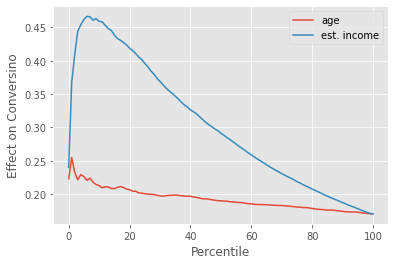

In [13]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_low", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino");
plt.legend();

Comme nous l'avions prédit, ceux avec un `estimated_income` élevé, ce qui se traduit par une conversion de base élevée, ont un effet de traitement beaucoup plus important.

Maintenant, dans l'autre situation où la conversion est élevée en moyenne, ceux avec **une conversion de base élevée auront un effet de traitement plus faible**. Par conséquent, il est déconseillé de cibler ceux avec un `estimated_income` élevé. Nous pouvons voir cela grâce à la courbe d'effet cumulatif inversée, qui montre que ceux avec un `estimated_income` élevé ont un effet de traitement plus faible.

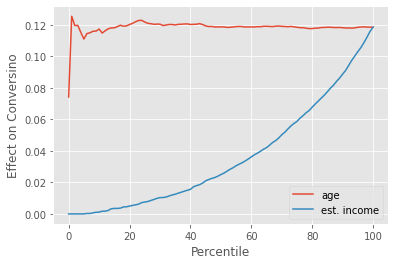

In [14]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_high", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversino")
plt.legend();

Pour résumer, ce que nous avons observé, c'est que, lorsque le résultat est binaire, l'effet du traitement tend à être dominé par la courbure (dérivée) de la fonction logistique.

![image.png](data/img/hte-binary-outcome/logistic.png)

Par exemple, dans notre problème de conversion, si la **conversion moyenne est faible**, nous nous trouvons à gauche de la courbe logistique, et l'**effet du traitement sera plus élevé pour une conversion de base élevée**. Cela se traduirait par une politique de nudge qui prône le traitement (nudge) des clients ayant déjà une probabilité élevée de conversion. En revanche, si la **conversion moyenne est élevée**, nous serons à droite de la courbe logistique, où la dérivée (et donc l'effet du traitement) sera **plus élevée pour les clients ayant une conversion de base plus faible**.

Cela fait certainement beaucoup à retenir, mais nous pouvons simplifier : **traitez simplement ceux qui sont plus proches d'une conversion de base de 50%**. L'argument mathématique ici est assez solide : la dérivée de la fonction logistique est à son maximum à 50%, donc traitez simplement les unités les plus proches de ce point.

Ce qui est encore plus agréable, c'est que c'est l'un des rares cas où le savoir commun correspond aux mathématiques. Dans le marketing, où ces problèmes de conversion sont très courants, il existe une croyance selon laquelle nous ne devrions pas cibler les paris perdus (ceux avec une très faible probabilité de conversion) ni les victoires assurées (ceux avec une très haute probabilité de conversion). Au lieu de cela, nous devrions cibler ceux qui se situent au milieu. C'est assez fascinant, car c'est exactement la même chose que nous avons découvert en utilisant un argument causal plus formel.

# Traitement Continu et Non-Linéarité

Nous avons exploré en profondeur un exemple où les résultats binaires compliquent l'analyse des effets hétérogènes du traitement. Mais ce phénomène va au-delà du problème de conversion en marketing. Par exemple, en 2021, le monde a réussi à livrer son premier lot de vaccins approuvés contre le COVID-19 au grand public. À l'époque, une question cruciale était de savoir qui devait recevoir le vaccin en premier. Sans surprise, il s'agissait d'un problème d'effet hétérogène du traitement. Les décideurs politiques souhaitaient vacciner en priorité ceux qui en bénéficieraient le plus. Dans cette situation, l'effet du traitement est d'éviter la mort ou l'hospitalisation. Alors, dont la mortalité ou l'hospitalisation a le plus diminué après avoir reçu une injection ? Dans la plupart des pays, il s'agissait des personnes âgées et des personnes ayant des problèmes de santé préexistants (comorbidités). Maintenant, ce sont les personnes qui sont **plus susceptibles de mourir en cas de COVID-19**. De plus, le taux de mortalité lié au COVID est heureusement bien inférieur à 50 %, ce qui nous place à gauche de la fonction logistique. Dans cette région, selon le même argument que nous avons avancé pour le marketing, il serait logique de traiter ceux ayant une probabilité élevée de mourir en cas de COVID-19, c'est-à-dire précisément les groupes que nous avons mentionnés plus tôt. Est-ce une coïncidence ? Peut-être. Gardez à l'esprit que je ne suis pas un expert en santé, donc je pourrais avoir tort ici. Mais la logique me semble très cohérente.

Dans les deux cas, que ce soit les nudges en marketing ou les vaccins contre le COVID-19, **le facteur clé qui complique l'hétérogénéité des effets du traitement est la non-linéarité de la fonction de résultat** $Y(0)$. Cette non-linéarité fait en sorte que, lorsque nous passons de $Y(0)$ à $Y(1)$, l'augmentation du résultat est principalement due à la courbure de la fonction de résultat. Nous avons vu comment cela se produisait pour un résultat binaire, où $E[Y|X]$ suit une forme logistique. Mais cela est encore plus général. En fait, c'est un problème qui revient fréquemment dans les affaires, en particulier si le traitement est une variable continue. Passons à un dernier exemple pour clarifier cette idée.

Considérons le problème classique du prix. Vous travaillez pour une entreprise de streaming, comme Netflix ou HBO. Une question clé que l'entreprise veut résoudre est de savoir quel prix facturer aux clients. Pour y répondre, ils réalisent une expérience où ils attribuent aléatoirement aux clients différents prix : 5 BRL/mois, 10 BRL/mois, 15 BRL/mois ou 20 BRL/mois. En procédant ainsi, ils espèrent non seulement déterminer la sensibilité des clients à l'augmentation des prix, mais aussi voir si certains types de clients sont plus sensibles que d'autres. Dans le graphique ci-dessous, vous pouvez voir les résultats de cette expérience ventilés par deux segments de clients : `A`, les clients avec un revenu estimé plus élevé, et `B`, les clients avec un revenu estimé plus faible.

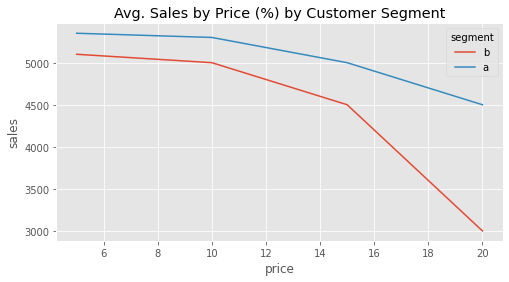

In [16]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

Avec ces données, l'entreprise souhaite répondre à la question suivante : qui est le plus sensible aux réductions ? En d'autres termes, comment pouvons-nous **classer les clients en fonction de leur sensibilité au prix (élasticité-prix des ventes)** ? En regardant la courbe, nous avons l'impression que le segment `A` est globalement moins sensible aux réductions, bien qu'il génère plus de revenus. Cependant, nous pouvons également voir qu'il y a une certaine courbure. En fait, si nous prenons cette courbure en compte, le classement des effets du traitement ne se limite plus seulement aux clients des segments `A` et `B`. L'effet du traitement dépendra également de leur position sur la courbe de traitement. Par exemple, l'effet du traitement de passer de 15 BRL à 10 BRL pour les clients du segment `A` est plus élevé que l'effet du traitement de passer de 5 BRL à 10 BRL pour les clients du segment `B` :

$$
E[Y(10) - Y(5) | Seg=B] < E[Y(15) - Y(10) | Seg=A]
$$

Si nous devions classer les effets de traitement résultants de cette expérience, cela ressemblerait à quelque chose comme ceci :

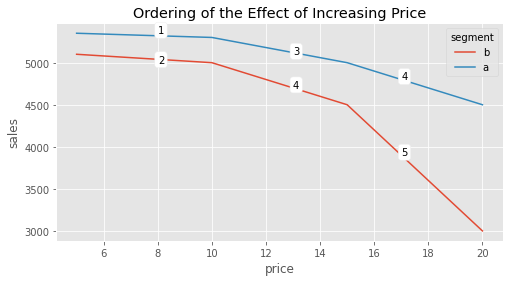

In [36]:
plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")

plt.annotate("1", (8, 5350), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("2", (8, 5000), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("3", (13, 5100), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (13, 4700), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (17, 4800), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("5", (17, 3900), bbox=dict(boxstyle="round", fc="1"))

plt.title("Ordering of the Effect of Increasing Price");

Tout comme dans le cas où le résultat était binaire, dans cet exemple, **l'effet du traitement est corrélé avec le résultat**. Plus les ventes sont élevées (prix plus bas), plus l'effet du traitement est faible en termes absolus ; plus les ventes sont faibles (prix plus élevé), plus l'effet absolu du traitement est faible. Mais dans ce cas, la situation est encore plus compliquée, car l'**effet n'est pas seulement corrélé avec le résultat, mais aussi avec le niveau du traitement**. Cela rend les questions contrefactuelles plus difficiles à répondre. Par exemple, imaginez un instant que vos données expérimentales ressemblent en réalité au graphique suivant, où vous testez des prix plus élevés pour le segment `A` (population aisée) mais seulement des prix plus bas pour la population `B`. C'est très courant, car les entreprises veulent souvent expérimenter autour du traitement qu'elles estiment être le plus raisonnable.

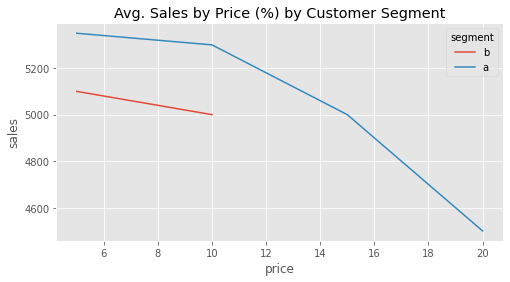

In [45]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data.loc[lambda d: (d["segment"] == "a") | (d["price"] < 12) ], x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

Maintenant, si vous agrégiez naïvement les résultats de l'effet du traitement, cela donnerait l'impression que le segment `A` est beaucoup plus élastique (a un effet de traitement absolu plus élevé) à l'augmentation des prix que le segment `B`. Mais cela n'est vrai que parce que, pour le segment `B`, vous avez exploré la région où l'effet du traitement est faible.

Alors, que pouvez-vous faire lorsque les effets du traitement changent en fonction de votre position par rapport au traitement et au résultat ? Pour être honnête, c'est encore un domaine de recherche actif. En termes pratiques, la meilleure chose à faire est d'être **très prudent** lorsque vous essayez de répondre à la question de savoir quel type de client est le plus sensible au traitement. Assurez-vous que les types de clients comparés ont tous reçu une distribution de traitement similaire. Sinon, soyez très sceptique quant à l'extrapolation de l'effet du traitement. Par exemple, dans l'exemple ci-dessus, même si le client `B` semble moins sensible à l'augmentation des prix, vous ne savez pas si cela restera le cas si vous attribuez des prix plus élevés au-delà de 10 BRL à ce segment.

Une autre chose que vous pouvez essayer de faire est de linéariser la courbe de réponse. L'idée ici est d'éliminer la courbure en transformant le traitement ou le résultat (ou les deux) de manière à ce que la relation entre eux ressemble à une ligne. Puisqu'une ligne a une dérivée constante, cela éliminerait le problème de l'effet du traitement qui change en fonction de la position sur la courbe. Par exemple, si nous prenons notre variable de prix et la transformons en la rendant négative, en l'exponentiant par 4 et en inversant le signe, nous obtenons une relation quelque peu linéaire. Dans ces données transformées, l'affirmation selon laquelle le segment `A` est moins sensible aux augmentations de prix que le segment `B` a beaucoup plus de sens, car cela ne dépend plus de l'endroit où nous nous trouvons sur la courbe.

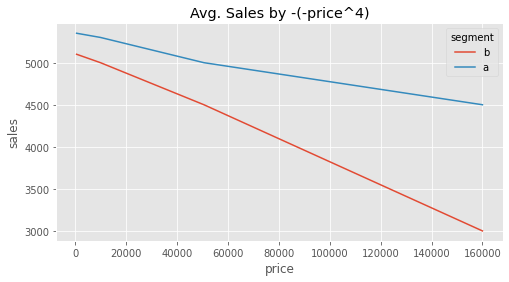

In [109]:

plt.figure(figsize=(8,4))
sns.lineplot(data=data.assign(price = lambda d: -1*(-d["price"]**4)),
             x="price", y="sales", hue="segment")
plt.title("Avg. Sales by -(-price^4)");

Cependant, cette approche présente de nombreux inconvénients. Tout d'abord, il n'est pas toujours possible de linéariser une courbe. Dans notre exemple, vous pouvez clairement voir que cette linéarisation n'est pas parfaite. Mais plus important encore, parfois, il n'est pas judicieux, d'un point de vue commercial, de supprimer la courbure. Dans notre exemple de tarification, il se peut très bien que nous soyons à l'aise avec l'idée de considérer le client `A` au prix de 15 BRL comme plus sensible que le client `B` au prix de 5 BRL. Cela nous amènerait à prendre une décision raisonnable de baisser le prix du client `A` de 15 à 10 BRL, mais de ne rien changer au prix du client `B`.

## Concepts Clés

Je réalise que j'ai peut-être soulevé plus de questions que de réponses, mais parfois, la meilleure chose à faire face à un problème est d'en être pleinement conscient. Dans ce chapitre, j'espère avoir réussi à vous sensibiliser aux complications qui surviennent lorsque le résultat qui nous intéresse est non linéaire.

C'est un problème courant et plus étudié dans le cas des résultats binaires. Dans ce cas, l'effet du traitement tend à être plus élevé plus nous sommes proches d'un résultat moyen de 0,5. Étant donné que le résultat est borné entre 0 et 1, les effets tendent à être très faibles si nous sommes trop proches de 0 ou de 1.

Les choses se compliquent avec les non-linéarités qui surviennent dans les situations de résultats continus. Ici, le mieux que vous puissiez faire est de réfléchir très attentivement au problème. Essayez de répondre à la question de savoir si vous vous souciez davantage de l'effet du traitement indépendamment de la base du traitement ou si la base est importante. Cela seul sera un principe directeur précieux.

## Référence

La plupart des éléments écrits ici proviennent de mon expérience personnelle avec ce problème. Cependant, j'ai trouvé un article académique qui aborde ce sujet : *Causal Classification: Treatment Effect Estimation vs. Outcome Prediction*, de Fernández-Loría et Provost, qui traite du cas où l'effet du traitement est corrélé avec la variable de résultat.
 
## Contribuer

Causal Inference for the Brave and True est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).